# BatSim

In this notebook, we aim to provide the necessary code for the protocol explained in the paper (https://arxiv.org/abs/2410.16567). To simplify the process, we have encapsulated all the code in a package called "BatSim" (Battery Simulation). This package is composed of several parts, as illustrated in the following diagram.

![BatSim Package Overview](BatSim_Package_Overview.png)

The package consists of four main sub-packages, which we will explain one by one:

1. **Physical**: This sub-package is based on a model that charges the Quantum Battery (QB) and correlates it with an ancilla using a unitary gate generated from the Hamiltonian as explained in the paper.


The "Physical" has two main modules:
   - **Daemonic**: Responsible for daemonic work extraction.
   - **Unconditional**: Responsible for unconditional work extraction.

Each of these modules has two attributes:
   - **Theory**: Contains the code needed for theoretical results.
   - **Implement**: Contains the code needed for implementation results on real hardware.

2. **BestQubits**: This sub-package is designed to find the best qubits with low readout error to maximize the performance of IBM devices and enhance the results. It includes one module called **Select**, which has one attributes:
   - **Q_Physical**: Selects the best qubits for the Physical model explaiend in the paper.

3. **Calibration**: This sub-package has one module called **Data**, which includes an attribute **Noise_Data**. This attribute obtains the parameters needed to engineer our proposed noise model, mimicking hardware behavior in theoretical calculations and finding the optimal unitary gates.

4. **Plot**: This sub-package is designed for plotting the results in two modes:
   - **Single Mode**: For plotting the results of either the noisy or ideal case.
   - **Comparison Mode**: For comparing the noisy and ideal cases.

The "Plot" sub-package includes a module called **data_plot**, which has two attributes:
   - **specifications**: For single plotting.
   - **compare**: For comparison plotting.

By organizing the code in this manner, we aim to provide a clear, structured approach to producing and analyzing the results presented in the paper.

In [12]:
# Importing necessary modules and classes from BatSim package
from BatSim.Physical import Unconditional, Daemonic  # Importing Unconditional and Daemonic from RyCnot. If you intend to use the Physical model in the code, you need to replace 'RyCnot' with 'Physical'.
from BatSim.Calibration import Data  # Importing Data from Calibration
from BatSim.BestQubits import Select  # Importing Select from BestQubits
from BatSim.Plot import data_plot  # Importing data_plot from Plot

# Importing necessary functions and constants
from math import pi, sqrt, exp  # Importing pi, sqrt, and exp functions/constants from math module

# Importing Qiskit Aer Simulator from qiskit_aer package
from qiskit_aer import AerSimulator

# Importing IBMProvider and QiskitRuntimeService from qiskit_ibm_provider and qiskit_ibm_runtime packages
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService

# Saving IBM Quantum account credentials using QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_quantum",  # Specify the channel (e.g., "ibm_quantum")
                                  token="INSERT YOUR TOKEN",  # Insert your IBM Quantum token here
                                  overwrite=True)  # Overwrite existing credentials if present


# Define Initial Parameters

In this cell, we will set the parameters for running the code. These parameters include the number of steps we want the collisional model to perform, the charging angle for the RyCNOT model, and omega and kappa, which are the parameters for the physical Hamiltonian model. Finally, we will specify the number of shots we aim to run the circuits.

In [13]:
Steps = 10  # Number of steps for the collisional model
alpha = 1  # drving field parameter for the physical Hamiltonian model
kappa = 1  # coupling parameter for the physical Hamiltonian model
shots = 10000  # Number of shots for running the circuit

# Hardware Specefications

Here, we will set the backend for running our circuits and identify the best qubits available on the backend to enhance our results.

In [14]:
omega = alpha
# Initialize Qiskit Runtime Service
service = QiskitRuntimeService(channel="ibm_quantum")

# Get the backend information for IBM Osaka
backend = service.get_backend('ibm_sherbrooke')

# Retrieve the backend properties
properties = backend.properties()

# Select the best qubits using the Q_RyCnot model from the Select module. For the Physical model, you need to just change the Q_RyCnot to Q_Physical.
qubits = Select.Q_Physical(Steps=Steps, omega = omega, kappa = kappa , backend=backend)
#qubits = Select.Q_RyCnot(Steps=Steps, Charge= Charge , backend=backend)
qubits = qubits[0]# Extract the selected qubits


# Convert backend properties to a dictionary for easier handling
backend_data = properties.to_dict()

Battery = qubits[0]



# Circuit Executions (Noisy)

This cell is dedicated to first finding the parameters like P01, P10, pa, and pd for the engineering noise model that we want to implement in our model. Secondly, we run the code for finding the daemonic and unconditional work extraction in both theoretical and implementation contexts. The theoretical context also produces a CSV file containing the optimal unitary work extraction elements needed for implementation on real devices. We then execute the implementation using the backend, qubit indices, and parameters that were defined previously in the above cells. 

In [15]:
# Obtain noise parameters from the Data module
P01, P10, pa, pd = Data.Noise_Data(backend=backend, shots=shots, qubits=qubits, simulator=True)

# If running on a simulator, uncomment the following line; otherwise, leave it disabled
backend = AerSimulator().from_backend(backend)


P01: 0.0038, P10: 0.0037, pa: 9.11889106447461e-08, pd: 6.122757745252727e-08


In [16]:
# Calculate theoretical results using the Daemonic module for passive energy after optimal unitary work extraction
Passive_Theory = Daemonic.Theory(Steps=Steps,omega = omega, kappa = kappa, pa=pa, pd=pd, P01=P01, P10=P10)

# Implement the Daemonic work extraction on the backend to calculate the passive energy
Passive_Im = Daemonic.Implement(Steps=Steps, omega = omega, kappa = kappa, backend=backend, shots=shots, qubits=qubits)

# Calculate theoretical results using the Unconditional module for passive energy and ergCXotropy
Energy_Theory, Ergotropy_Theory = Unconditional.Theory(Steps=Steps, omega = omega, kappa = kappa, pa=pa, pd=pd)

# Implement the Unconditional model on the backend to get unconditional work extraction and final energy
Energy_Im, Ergotropy_Im = Unconditional.Implement(Steps=Steps, omega = omega, kappa = kappa, backend=backend, shots=shots, qubits=qubits)

# Calculate the theoretical and implemented Daemonic results.
Daemonic_Theory = [xi - yi for xi, yi in zip(Energy_Theory, Passive_Theory)]
Daemonic_Im = [xi - yi for xi, yi in zip(Energy_Im, Passive_Im)]

# Circuit Executions (Ideal)

This cell performs the same process as mentioned in the previous cell, with the fundamental difference of not considering noise in the calculations and setting the noise parameters to the ideal case. Similarly, we run the code for finding the daemonic and unconditional work extraction in both theoretical and implementation contexts. The theoretical context also produces a CSV file containing the optimal unitary work extraction elements needed for implementation on real devices. We then execute the implementation using the backend, qubit indices, and parameters that were defined previously in the above cells.

In [17]:
P01, P10, pa, pd = 0, 0, 0 ,0
# Calculate theoretical results using the Daemonic module for passive energy after optimal unitary work extraction
Passive_TheoryIdeal = Daemonic.Theory(Steps=Steps,omega = omega, kappa = kappa, pa=pa, pd=pd, P01=P01, P10=P10)

# Implement the Daemonic work extraction on the backend to calculate the passive energy
Passive_ImIdeal = Daemonic.Implement(Steps=Steps, omega = omega, kappa = kappa, backend=backend, shots=shots, qubits=qubits)

# Calculate theoretical results using the Unconditional module for passive energy and ergCXotropy
Energy_TheoryIdeal, Ergotropy_TheoryIdeal = Unconditional.Theory(Steps=Steps, omega = omega, kappa = kappa, pa=pa, pd=pd)

# Implement the Unconditional model on the backend to get unconditional work extraction and final energy
Energy_ImIdeal, Ergotropy_ImIdeal = Unconditional.Implement(Steps=Steps, omega = omega, kappa = kappa, backend=backend, shots=shots, qubits=qubits)

# Calculate the theoretical and implemented Daemonic results.
Daemonic_TheoryIdeal = [xi - yi for xi, yi in zip(Energy_TheoryIdeal, Passive_TheoryIdeal)]
Daemonic_ImIdeal = [xi - yi for xi, yi in zip(Energy_ImIdeal, Passive_ImIdeal)]

# Standard Deviation

In [18]:

delte_E_init2 = [] 
delta_E_fin_2 = [] 
std_curve = []

for item in Energy_Im:
    std = item*(1 - item)
    delte_E_init2.append(std)
for item in Passive_Im:
    std = item*(1 - item)
    delta_E_fin_2.append(std)


for i in range(len(Energy_Im)):
    std = sqrt((delte_E_init2[i] + delta_E_fin_2[i])/shots)
    std_curve.append(std)

delte_E_init2 = [] 
delta_E_fin_2 = [] 
std_curveIdeal = []

for item in Energy_ImIdeal:
    std = item*(1 - item)
    delte_E_init2.append(std)
for item in Passive_ImIdeal:
    std = item*(1 - item)
    delta_E_fin_2.append(std)


for i in range(len(Energy_ImIdeal)):
    std = sqrt((delte_E_init2[i] + delta_E_fin_2[i])/shots)
    std_curveIdeal.append(std)

# Plotting the Results 

In the next three cells, we plot the results for the noisy case, the ideal case, and a comparison plot, respectively.

c:\Users\Navid Elyasi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Navid Elyasi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


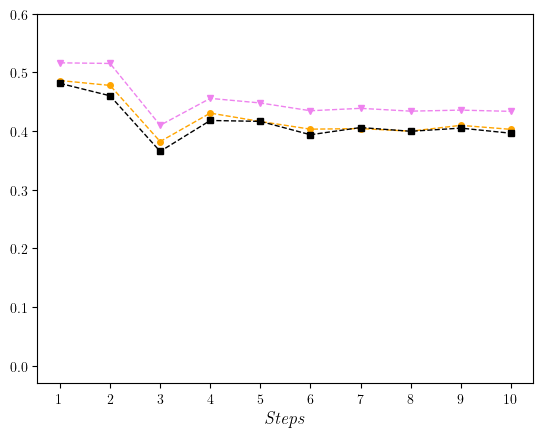

In [19]:
data_plot.compare(std_dev = std_curve, 
                  std_devIdeal = std_curveIdeal,
                  Ergotropy_TheoryIdeal=Ergotropy_TheoryIdeal, 
                  error = False,
                  Ergotropy_ImIdeal=Ergotropy_ImIdeal,
                  Daemonic_Theory=Daemonic_Theory,  
                  Daemonic_TheoryIdeal=Daemonic_TheoryIdeal, 
                  Daemonic_Im=Daemonic_Im, 
                  Daemonic_ImIdeal=Daemonic_ImIdeal,
                  noise = True,
                  legend= False, 
                  file_name=f"compare_Physical_noise_kappa={kappa}",
                  kappa = kappa)

e:\Thesis\Prof.Marco Genoni\OQB-implementation---Batsim\BatSim\Plot\data_plot.py:117: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_axis, Daemonic_Im, yerr=std_dev, color='orange', linestyle='dashed', fmt='-o', markersize=4, label= r'$\overline{\mathcal{W}}_{\{\tilde{\Pi}_{{\bf a}_n},\hat{U}_{{\bf a}_n}^{\sf noisy} \} }$')
e:\Thesis\Prof.Marco Genoni\OQB-implementation---Batsim\BatSim\Plot\data_plot.py:118: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_axis, Daemonic_ImIdeal, yerr=std_dev, color='black', linestyle='dashed', fmt='-s', markersize=4, label= r'$\overline{\mathcal{W}}_{\{\tilde{\Pi}_{{\bf a}_n},\hat{U}_{{\bf a}_n}^{\sf ideal} \} }$')


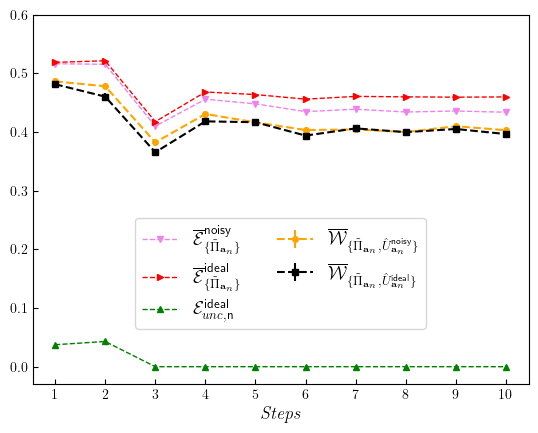

In [20]:
data_plot.compare(std_dev = std_curve, 
                  std_devIdeal = std_curveIdeal,
                  Ergotropy_TheoryIdeal=Ergotropy_TheoryIdeal, 
                  error =True,
                  Ergotropy_ImIdeal=Ergotropy_ImIdeal,
                  Daemonic_Theory=Daemonic_Theory,  
                  Daemonic_TheoryIdeal=Daemonic_TheoryIdeal, 
                  Daemonic_Im=Daemonic_Im, 
                  Daemonic_ImIdeal=Daemonic_ImIdeal,
                  noise = True,
                  legend= True, 
                  file_name=f"Physical_nonoise_kappa={kappa}",
                  kappa = kappa)